# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split_data
import post_hoc

# Evaluate logits

In [5]:
MODEL_ARC = 'resnet50'
DATASET = 'ImageNet'

In [6]:
logits,labels = upload_logits(MODEL_ARC,DATASET,PATH_MODELS, 
                            split = 'test', device = dev)
risk = measures.wrong_class(logits,labels).float()
logits = post_hoc.centralize(logits).sort(descending=True).values

In [7]:
METRIC = metrics.N_AURC

# Optimization and RC

In [8]:
p  = post_hoc.MaxLogit_p(logits,risk = risk, return_p=True)[1]
T = post_hoc.optimize.T(logits=logits,risk=risk)

In [38]:
metrics.AUROC(risk,logits.norm(2,-1))

0.24549674443545993

In [9]:
aurocs_semisoftmax = []
aurocs_semimaxlogit_p = []
aurocs_logit = []
aurocs_kenergy = []
logit_mean = []
for k in range(logits.size(-1)):
    aurocs_semisoftmax.append(METRIC(risk,measures.MSP(logits[:,:k+1])))
    aurocs_semimaxlogit_p.append(METRIC(risk,post_hoc.MaxLogit_p(logits[:,:k+1],risk = risk)))
    aurocs_logit.append(METRIC(risk,logits[:,k]))
    logit_mean.append(logits[:,k].mean().item())
    aurocs_kenergy.append(METRIC(risk,measures.energy(logits[:,:k+1])))

In [10]:
def z1_z2(logits):
    top2 = logits.topk(2,-1).values.T
    return top2[0]/top2[1]   
def z1_zn(logits):
    return logits.max(-1).values/logits.min(-1).values.abs()


In [11]:
metrics.N_AURC(risk,z1_z2(logits))

0.18625375380587325

In [12]:
metrics.N_AURC(risk,z1_zn(logits))

0.509254075529521

In [13]:
metrics.N_AURC(risk,post_hoc.MaxLogit_p(logits,risk = risk))

0.16757056695342037

$k-MSP = \frac{e^{z_1/T}}{\sum_{i=1}^K e^{z_i/T} + \sum_{j=k+1}^C e^{z_j/T}}$

In [ ]:
metrics.AUROC(risk,maxlogit(logits))
metrics.AUROC(risk,random)
metrics.AUROC(risk,secondlogit(logits))


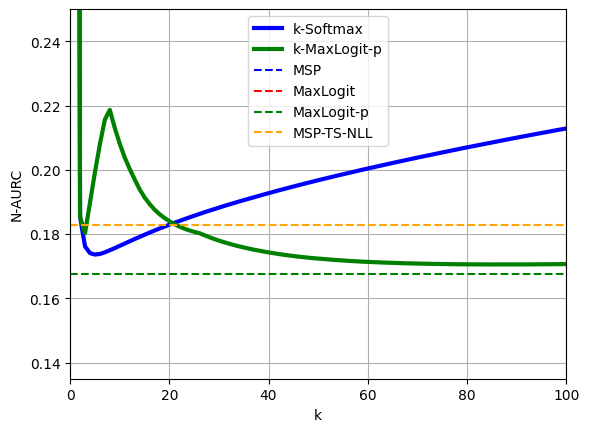

In [14]:
plt.plot(range(1,logits.size(-1)+1),aurocs_semisoftmax,'-',label = 'k-Softmax', linewidth = 3.0, color = 'blue')
#plt.plot(aurocs_logit,'-', label = 'k_th Logits', linewidth = 3.0, color = 'red')
plt.plot(range(1,logits.size(-1)+1),aurocs_semimaxlogit_p,'-', label = 'k-MaxLogit-p', linewidth = 3.0, color = 'g')
#plt.plot(aurocs_kenergy,'-', label = 'k Energy', linewidth = 3.0)
plt.axhline(METRIC(risk,measures.MSP(logits)),linestyle = '--',color = 'blue',label = 'MSP')
plt.axhline(METRIC(risk,measures.max_logit(logits)),linestyle = '--',color = 'r',label = 'MaxLogit')
plt.axhline(METRIC(risk,post_hoc.MaxLogit_p(logits,risk = risk)),linestyle = '--',color = 'g',label = 'MaxLogit-p')
plt.axhline(METRIC(risk,measures.MSP(logits.div(T))),linestyle = '--',color = 'orange',label = 'MSP-TS-NLL')
plt.grid()
plt.ylabel('N-AURC')
plt.xlabel('k')
plt.legend()
plt.xlim(0,100)
plt.ylim(top=0.25)
plt.show()

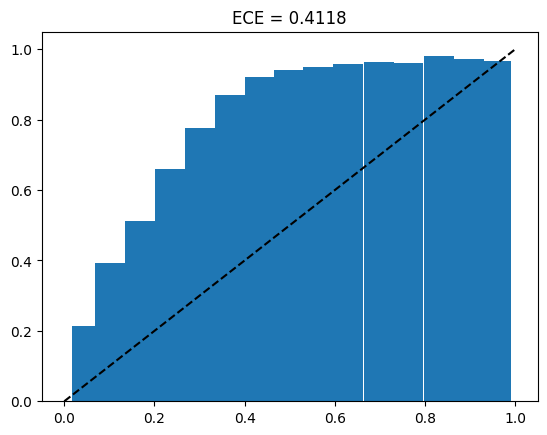

In [15]:
ece_fn = metrics.ECE(n_bins = 15)
plt.title(f'ECE = {ece_fn(measures.MSP(logits),risk).item():.4f}')
plt.bar(*ece_fn.diagram(measures.MSP(logits),risk),width = 1/15)
plt.plot([0,1],[0,1],'k--')

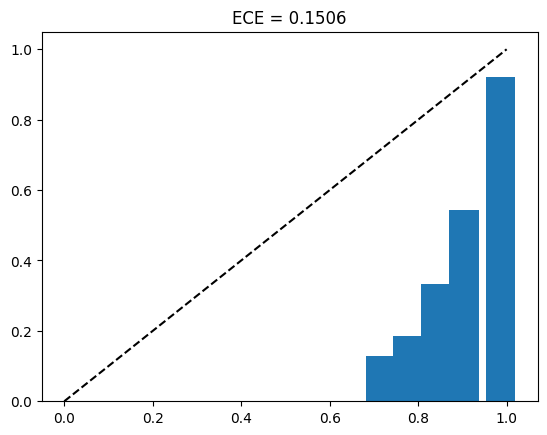

In [16]:

plt.title(f'ECE = {ece_fn(post_hoc.MaxLogit_p(logits,p=p),risk).item():.4f}')
plt.bar(*ece_fn.diagram(post_hoc.MaxLogit_p(logits,p=p),risk),width = 1/15)
plt.plot([0,1],[0,1],'k--')

$$ MaxLogit-p =  \max_c\frac{z_c}{\left(\sum_{i=1}^C |z_i|^p\right)^{1/p}}$$ 

In [17]:
sgn = ((0.5-(torch.tensor(aurocs_logit,device = dev)<1).float())/0.5)
sgn[0] = 1.0

In [18]:
np.min(aurocs_semimaxlogit_p)

0.16717618292587846

In [19]:
metrics.N_AURC(risk,measures.max_logit(post_hoc.normalize(logits,p)))

0.16757056695342037

In [20]:
p=6
metrics.N_AURC(risk,measures.max_logit(logits).div((logits.pow(p).mul(sgn)).sum(-1).pow(1/p)))

0.16750578931100676

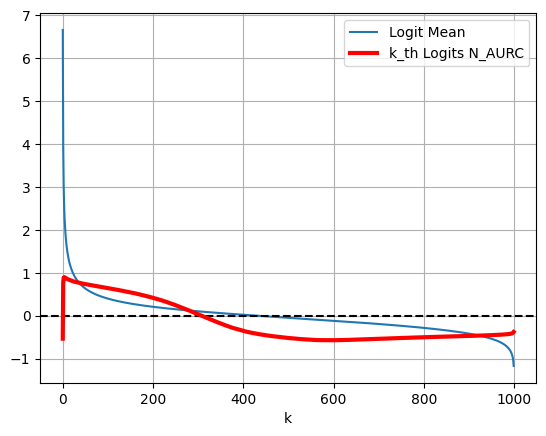

In [21]:
plt.plot(logit_mean, label = 'Logit Mean')
plt.axhline(0, linestyle = '--', color = 'black')
plt.plot(np.array(aurocs_logit)-1,'-', label = 'k_th Logits N_AURC', linewidth = 3.0, color = 'red')
plt.xlabel('k')
plt.legend()
plt.grid()

In [22]:
def MSP_T_1(logits, T = 1):
    return (logits-logits[:,0].unsqueeze(-1)).div(T).exp().sum(-1)
def MSP_T_2(logits, T = 1):
    return (logits-logits[:,0].unsqueeze(-1)).div(T).exp().sum(-1)-1
def MSP_T_3(logits, T = 1):
    return logits[:,0].div(T).exp().div(logits[:,1:].div(T).exp().sum(-1))
def MSP_T_4(logits, T = 1):
    return ((logits-logits[:,0].unsqueeze(-1)).div(T).exp().sum(-1)-1).pow(T)
def MSP_T_5(logits, T = 1):
    return (logits[:,1:]-logits[:,0].unsqueeze(-1)).exp().norm(1/T,-1)

In [23]:
metrics.AUROC(risk,-MSP_T_1(logits))

0.8060034493125812

In [24]:
metrics.AUROC(risk,measures.MSP(logits))

0.8060034493125812

In [25]:
metrics.AUROC(risk,-MSP_T_2(logits))

0.8060034493125812

In [26]:
metrics.AUROC(risk,MSP_T_3(logits))

0.8060034518967152

In [27]:
metrics.AUROC(risk,-MSP_T_4(logits))

0.8060034493125812

In [28]:
msp = []
msp_1 = []
msp_2 = []
msp_3 = []
msp_4 = []
msp_5 = []
T_range = np.arange(0.01,2,0.01)
for T in T_range:
    msp.append(metrics.AUROC(risk,measures.MSP(logits.div(T))))
    msp_1.append(metrics.AUROC(risk,-MSP_T_1(logits,T)))
    msp_2.append(metrics.AUROC(risk,-MSP_T_2(logits,T)))
    msp_4.append(metrics.AUROC(risk,-MSP_T_4(logits,T)))
    msp_5.append(metrics.AUROC(risk,-MSP_T_5(logits,T)))
    try: msp_3.append(metrics.AUROC(risk,MSP_T_3(logits,T)))
    except: msp_3.append(np.nan)
#for i,v in enumerate(msp_3):
#    if v==0:
        

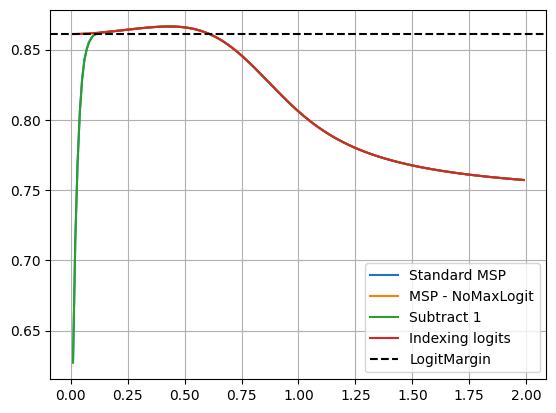

In [29]:
plt.plot(T_range,msp, label = 'Standard MSP')
#plt.plot(T_range,msp_1, label = 'Form 1')
#plt.plot(T_range,msp_2, label = 'Form 2')
plt.plot(T_range,msp_3, label = 'MSP - NoMaxLogit')
plt.plot(T_range,msp_4, label = 'Subtract 1')
plt.plot(T_range,msp_5, label = 'Indexing logits')
plt.axhline(metrics.AUROC(risk,measures.margin_logits(logits)), linestyle = '--', color = 'k', label = 'LogitMargin')
plt.grid()
plt.legend()

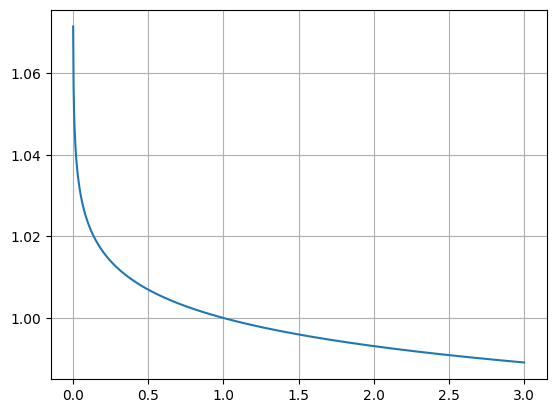

In [30]:
x = np.linspace(0.001,3,1000)
y = np.power(x,-0.01)
plt.plot(x,y)
plt.grid()

In [31]:
x = np.linspace(0,10)
fn = lambda x,p: np.power(x,p-1)
y = []
for p in range(1,6):
    y.append(fn(x,p))

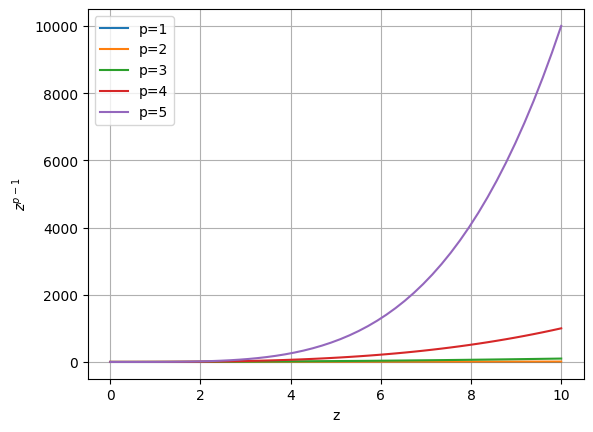

In [32]:
for p,v in enumerate(y):
    plt.plot(x,v,label = f'p={p+1}')
plt.grid()
plt.legend()
plt.xlabel('z')
plt.ylabel(r'$z^{p-1}$')
plt.show()
